<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/gan/inda_gan_train_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
filePath ="/content/gdrive/MyDrive/neural_data/CDF-INDA.zip"
extractPath = "/content/dataset"

In [4]:
import zipfile

zip_ref = zipfile.ZipFile(filePath, 'r')
zip_ref.extractall(extractPath)
zip_ref.close()

In [5]:
import os
# List the files in the extracted directory
image_files = [f for f in os.listdir(extractPath + "/CDF-INDA") if os.path.isfile(os.path.join(extractPath  + "/CDF-INDA", f))]

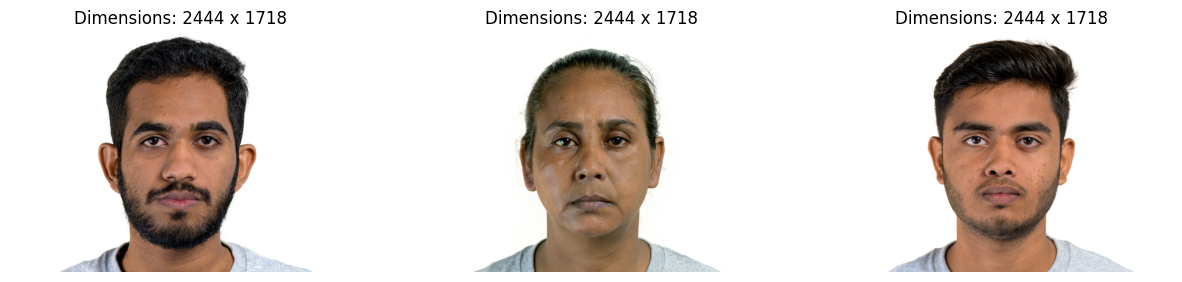

In [6]:
from PIL import Image
# Load the first 3 images
images = []
image_dims = []
for i in range(min(3, len(image_files))):
    img_path = os.path.join(extractPath + "/CDF-INDA", image_files[i])
    img = Image.open(img_path)
    images.append(img)
    image_dims.append(img.size)  # (width, height)

# Plot the first 3 images with their dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, dim in zip(axes, images, image_dims):
    ax.imshow(img)
    ax.set_title(f'Dimensions: {dim[0]} x {dim[1]}')
    ax.axis('off')

plt.show()

In [9]:
# Define the path to the extracted data
data_path = "/content/dataset/"

# Define data generator for custom data
# Create an instance of the ImageDataGenerator with rescaling and zoom range
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(88, 120),
    batch_size=32,
    class_mode=None  # No labels required for GANs
)

Found 138 images belonging to 1 classes.


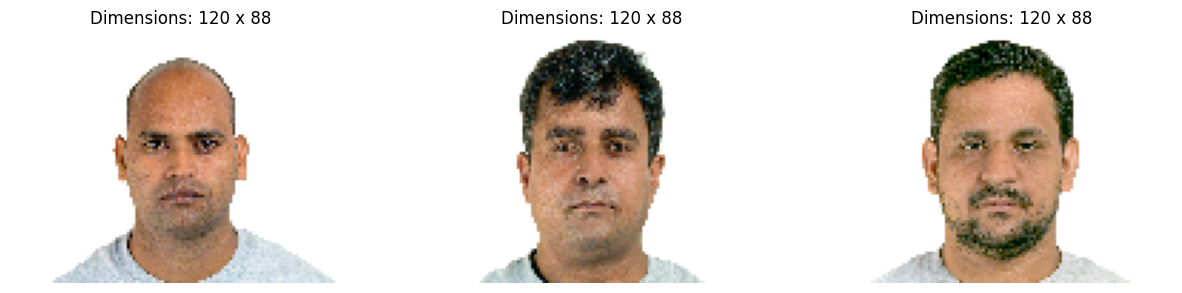

In [11]:
# Get the first batch of images
images_batch = next(train_generator)
first_three_images = images_batch[:3]

# Plot the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img in zip(axes, first_three_images):
    ax.imshow(img)
    ax.set_title(f'Dimensions: 120 x 88')
    ax.axis('off')

plt.show()


In [12]:
# Generator model
def build_generator():
    model = Sequential()
    model.add(Dense(256 * 15 * 11, activation='relu', input_dim=100))
    model.add(Reshape((11, 15, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    #model.summary()
    return model


In [13]:
# Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(88, 120, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    return model

In [14]:
# Build and compile the discriminator
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Verify the models' output shapes
print("Generator output shape:", generator.output_shape)
print("Discriminator input shape:", discriminator.input_shape)

Generator output shape: (None, 88, 120, 3)
Discriminator input shape: (None, 88, 120, 3)


In [16]:
# GAN model (stacked generator and discriminator)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan = Model(z, validity)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


In [17]:
# Define constants
epochs = 200
batch_size = 32
codings_size = 100
save_interval = 50

In [18]:
# Save generated images
def save_images(epoch, generator, examples=3, dim=(1, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images + 0.5  # Rescale images 0 - 1
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.close()

In [19]:
# Function to train GAN
def train_gan(generator, discriminator, GAN, train_generator, epochs, batch_size, codings_size):
    for epoch in range(epochs):
        print(f"Currently on Epoch {epoch+1}")
        i = 0
        for X_batch in train_generator:
            i += 1
            if i % 2 == 0:
                print(f"\tTraining on batch number {i} of {len(train_generator)}")

            # Training discriminator
            # Ensure the noise and labels match the actual batch size
            actual_batch_size = X_batch.shape[0]  # Get actual batch size
            noise = tf.random.normal(shape=[actual_batch_size, codings_size])
            gen_images = generator(noise)
            X_fake_vs_real = tf.concat([gen_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * actual_batch_size + [[1.]] * actual_batch_size, shape=[2 * actual_batch_size, 1])
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_vs_real, y1)

            # Training generator
            # Ensure the noise matches the actual batch size
            noise = tf.random.normal(shape=[actual_batch_size, codings_size])
            y2 = tf.constant([[1.]] * actual_batch_size)
            discriminator.trainable = False
            GAN.train_on_batch(noise, y2)

        # Save generated images every 50 epochs
        if (epoch + 1) % save_interval == 0:
            save_images(epoch, generator)

    print("COMPLETED")

In [ ]:
train_gan(generator, discriminator, gan, train_generator, epochs, batch_size, codings_size)

Currently on Epoch 1
	Training on batch number 2 of 5
	Training on batch number 4 of 5
	Training on batch number 6 of 5
	Training on batch number 8 of 5
	Training on batch number 10 of 5
	Training on batch number 12 of 5
	Training on batch number 14 of 5
